[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ncerdan/HandsOnML/blob/master/04_Training_Models.ipynb)

# Linear Regression

## The Normal Equation

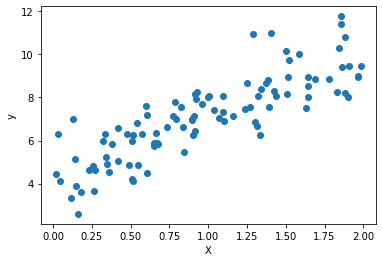

In [5]:
# make the data set
import numpy as np
import matplotlib.pyplot as plt

X = 2 * np.random.rand(100, 1);
y = 4 + 3 * X + np.random.randn(100, 1)

plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [10]:
# now lets compute theta using the normal equation
X_b = np.c_[np.ones((100, 1)), X]   # adds x0 = 1 in front of all x rows in X
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best  # close to 4, 3 but noise of randomness made it adjust

array([[4.32831527],
       [2.85313948]])

In [13]:
# now can make predictions with it
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]

y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.32831527],
       [10.03459424]])

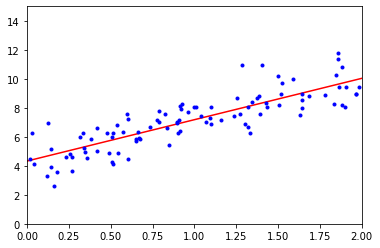

In [14]:
# visualize predictions
plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.show()

In [18]:
# now do it using sklearn
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(lin_reg.intercept_, lin_reg.coef_)    # notice it splits bias term from others

print(lin_reg.predict(X_new))

[4.32831527] [[2.85313948]]
[[ 4.32831527]
 [10.03459424]]


In [20]:
# this class is based on the scipy least squares function which you can use directly
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd  #same as above

# this function computes pseudoinverse of X

array([[4.32831527],
       [2.85313948]])

In [23]:
# can use pinv to compute pseudoinverse directly too
np.linalg.pinv(X_b).dot(y)  # same too!

# this method is more efficient and can handle situation where inversion not possible

array([[4.32831527],
       [2.85313948]])

## Batch Gradient Descent

In [25]:
# uses the whole batch of X at each iteration
eta = 0.1   # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)   # random initialization

for iteration in range(n_iterations):
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)   # from calculus
    theta = theta - eta * gradients

theta   # same as normal equation!

array([[4.32831527],
       [2.85313948]])

## Stochastic Gradient Descent

In [28]:
# implements SGD with simple learning schedule
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparams

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)   # still random init

for epoch in range(n_epochs):
    for i in range(m):                          # m iterations per round
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

theta       # really close in only 50 rounds!

array([[4.32067527],
       [2.85374244]])

In [31]:
# to use this in sklearn use SGD
# defaults to minimizing squared error
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)  # tol = tolerance to terminate
sgd_reg.fit(X, y.ravel())

sgd_reg.intercept_, sgd_reg.coef_

(array([4.35355495]), array([2.90495201]))

# Polynomial Regression



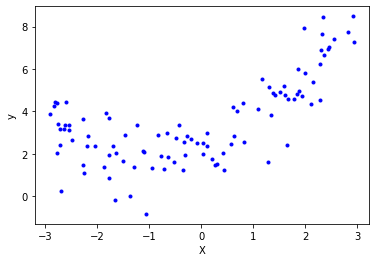

In [32]:
# make nonlinear data
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.plot(X, y, 'b.')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [50]:
# use sklearn's PolynomialFeatures to add the square of each feature as a new feature
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0])
print(X_poly[0])

# also adds combinations of features
# e.g. a, b --> poly_features(degree=3) --> a, a^2, a^3, b^2, b^3, ab, a^2b, ab^2

[-1.36612828]
[-1.36612828  1.86630649]


In [51]:
# now we can just fit it using LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.2442715]), array([[0.8312753 , 0.42786821]]))

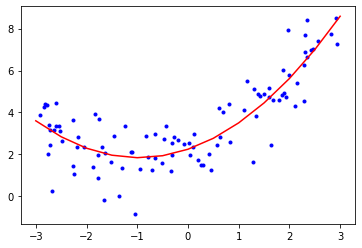

In [60]:
# visualize it
X_disp = np.arange(-3, 3.5, 0.5)

X_disp_poly = poly_features.fit_transform(X_disp.reshape(-1, 1))
y_disp = lin_reg.predict(X_disp_poly)

plt.plot(X, y, 'b.')
plt.plot(X_disp, y_disp, 'r-')
plt.show()

## Learning Curves

In [72]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='val')
    plt.axis([0, 80, 0, 3])
    plt.legend()
    plt.show()

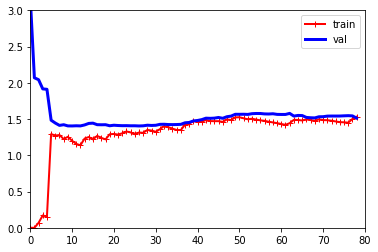

In [74]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

# both training and validation errors are similar but high = underfitting

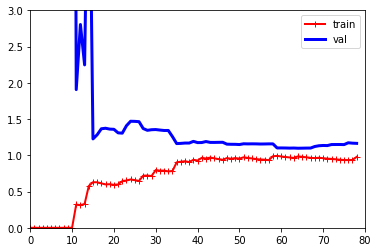

In [78]:
# now lets try it using a 10-degree polynomial
from sklearn.pipeline import Pipeline
polynomial_regression = Pipeline([
    ('poly_feature', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)

# Notes:
#   lower error on training data gap between training and validation = overfitting

# Regularized Linear Models